## Challenge

Do a little scraping or API-calling of your own.  Pick a new website and see what you can get out of it.  Expect that you'll run into bugs and blind alleys, and rely on your mentor to help you get through.  

Formally, your goal is to write a scraper that will:

1) Return specific pieces of information (rather than just downloading a whole page)  
2) Iterate over multiple pages/queries  
3) Save the data to your computer  

Once you have your data, compute some statistical summaries and/or visualizations that give you some new insights into your scraping topic of interest.  Write up a report from scraping code to summary and share it with your mentor.

# Craiglist Guitars For Sale In San Diego

In [1]:
import scrapy
from scrapy.crawler import CrawlerProcess


class CLSpider(scrapy.Spider):
    name = "CL"
    
    # Here is where we insert our API call.
    start_urls = [
        'https://sandiego.craigslist.org/search/sss?query=guitar&sort=rel',
    ]

    # Identifying the information we want from the query response and extracting it using xpath.
    def parse(self, response):
        # Iterate over every <article> element on the page.
        for posting in response.xpath('//p'):
            
            # Yield a dictionary with the values we want.
            yield {
                # This is the code to choose what we want to extract
                # You can modify this with other Xpath expressions to extract other information from the site
                'title': posting.xpath('a[@class="result-title hdrlnk"]/text()').extract_first(),
                'date': posting.xpath('time[@class="result-date"]/text()').extract_first(),
                'price': posting.xpath('span/span[@class="result-price"]/text()').extract_first()
            }
        next_page = response.xpath('//div/div/span[@class="buttons"]/a[3][@href]').extract_first()
        
        pagenum = int(re.findall(r'\d+',next_page)[0])
        
        if next_page is not None and pagenum < 10:
            next_page = response.urljoin(next_page)
            yield scrapy.Request(next_page, callback=self.parse)

# Tell the script how to run the crawler by passing in settings.
process = CrawlerProcess({
    'FEED_FORMAT': 'json',         # Store data in JSON format.
    'FEED_URI': 'cldata.json',  # Name our storage file.
    'ROBOTSTXT_OBEY': True,
    'USER_AGENT': 'ThinkfulDataScienceBootcamp_Katherine (thinkful.com)',
    'AUTOTHROTTLE_ENABLED': True,
    'HTTPCACHE_ENABLED': True,
    'LOG_ENABLED': False           # Turn off logging for now.
})

# Start the crawler with our spider.
process.crawl(CLSpider)
process.start()
print('Success!')

Success!


In [2]:
import pandas as pd

# Checking whether we got data 

guitars=pd.read_json('cldata.json')
print(guitars.shape)
guitars.head()

(120, 3)


,date,price,title
0,Jan 9,$60,Guitar Pedals-Electric Guitar
1,Jan 9,$35,"""New"" Guitar Amp 1x6.5"" 15 watt Keith Urban pl..."
2,Jan 8,$150,like new electric guitar lyon
3,Jan 8,$40,Cerwin Vega Guitar Speaker Cabinet
4,Jan 8,$380,Acoustic Guitar Recordin King RD-T16


These are the first 120 listings of guitars for sale in San Diego (1st page Craiglist) on 1/9/19.  Let's do some cleaning:

In [4]:
guitars['price'].isnull().sum()

4

In [6]:
guitars.dtypes

date     object
price    object
title    object
dtype: object

In [8]:
#remove $ signs and convert to float
import re

guitars.price = guitars.price.map(lambda x: None if x == None else int(re.sub('\$', '', str(x))))
guitars.head()

,date,price,title
0,Jan 9,60.0,Guitar Pedals-Electric Guitar
1,Jan 9,35.0,"""New"" Guitar Amp 1x6.5"" 15 watt Keith Urban pl..."
2,Jan 8,150.0,like new electric guitar lyon
3,Jan 8,40.0,Cerwin Vega Guitar Speaker Cabinet
4,Jan 8,380.0,Acoustic Guitar Recordin King RD-T16


In [11]:
guitars.dtypes

date      object
price    float64
title     object
dtype: object

In [9]:
guitprice = guitars[guitars.price>0]
average_price = guitprice.price.mean()
print(average_price)

228.18965517241378


The average price for a guitar sale on Craiglist in San Diego is $228.19.  Let's check out a chart to see how distributed the data is:

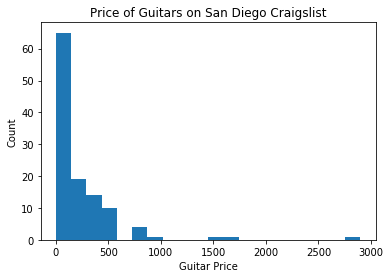

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(guitprice.price, bins=20)
plt.xlabel('Guitar Price')
plt.ylabel('Count')
plt.title('Price of Guitars on San Diego Craigslist')
plt.show()

Most guitar prices are listed under $600 with a few options in the thousands of dollars.  Checking the data, all sales do not include guitars, but have guitar-related items, such as a guitar speaker cabinet:

In [12]:
guitars.head()

,date,price,title
0,Jan 9,60.0,Guitar Pedals-Electric Guitar
1,Jan 9,35.0,"""New"" Guitar Amp 1x6.5"" 15 watt Keith Urban pl..."
2,Jan 8,150.0,like new electric guitar lyon
3,Jan 8,40.0,Cerwin Vega Guitar Speaker Cabinet
4,Jan 8,380.0,Acoustic Guitar Recordin King RD-T16


Further exploration for the types of items being sold:

In [21]:
guitars.sort_values(by=['price'])

,date,price,title
72,Jan 8,1.0,Guitar pedals for sale!
28,Jan 8,1.0,Guitar effects pedals
98,Jan 8,5.0,NEW ITEMS : Guitar Pedals / Effects / Synth / ...
18,Jan 8,7.0,﻿Matrix chromatic guitar / bass tuner
106,Jan 8,10.0,1950's Roy Rogers Acoustic Guitar
104,Jan 8,10.0,Prri's Leather Acoustic Guitar Strap
85,Jan 8,10.0,GUITAR CASE
84,Jan 8,10.0,Guitar tuner by First Act
13,Jan 8,14.0,"POISON ""FLESH AND BLOOD"" Piano Vocal Guitar Ta..."
89,Jan 8,15.0,GUITAR STAND
